## Import Libraries

In [1]:
# Importing Libraries
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers as KL
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D as Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing import image

## Load Data

In [2]:
TRAIN_PATH = '/kaggle/input/histopathologic-cancer-detection/train/'
TRAIN_LABELS = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
SIZE_IMG = 96
EPOCHS = 10

model_path = '../input/resnet-cancer-detection/my_model.h5'
saved_model = os.path.isfile(model_path)

In [3]:
df = pd.read_csv(TRAIN_LABELS, dtype=str)

#remove unwanted data detected by other kaggle users
df = df[df['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']
df = df[df['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

print(df['label'].value_counts(), 
      '\n\n', df.describe(), 
      '\n\n', df.head())

0    130907
1     89116
Name: label, dtype: int64 

                                               id   label
count                                     220023  220023
unique                                    220023       2
top     19ca9e2ac4c78b1bbee6e01e269d9774bc694739       0
freq                                           1  130907 

                                          id label
0  f38a6374c348f90b587e046aac6079959adf3835     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77     1
2  755db6279dae599ebb4d39a9123cce439965282d     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08     0
4  068aba587a4950175d04c680d38943fd488d6a9d     0


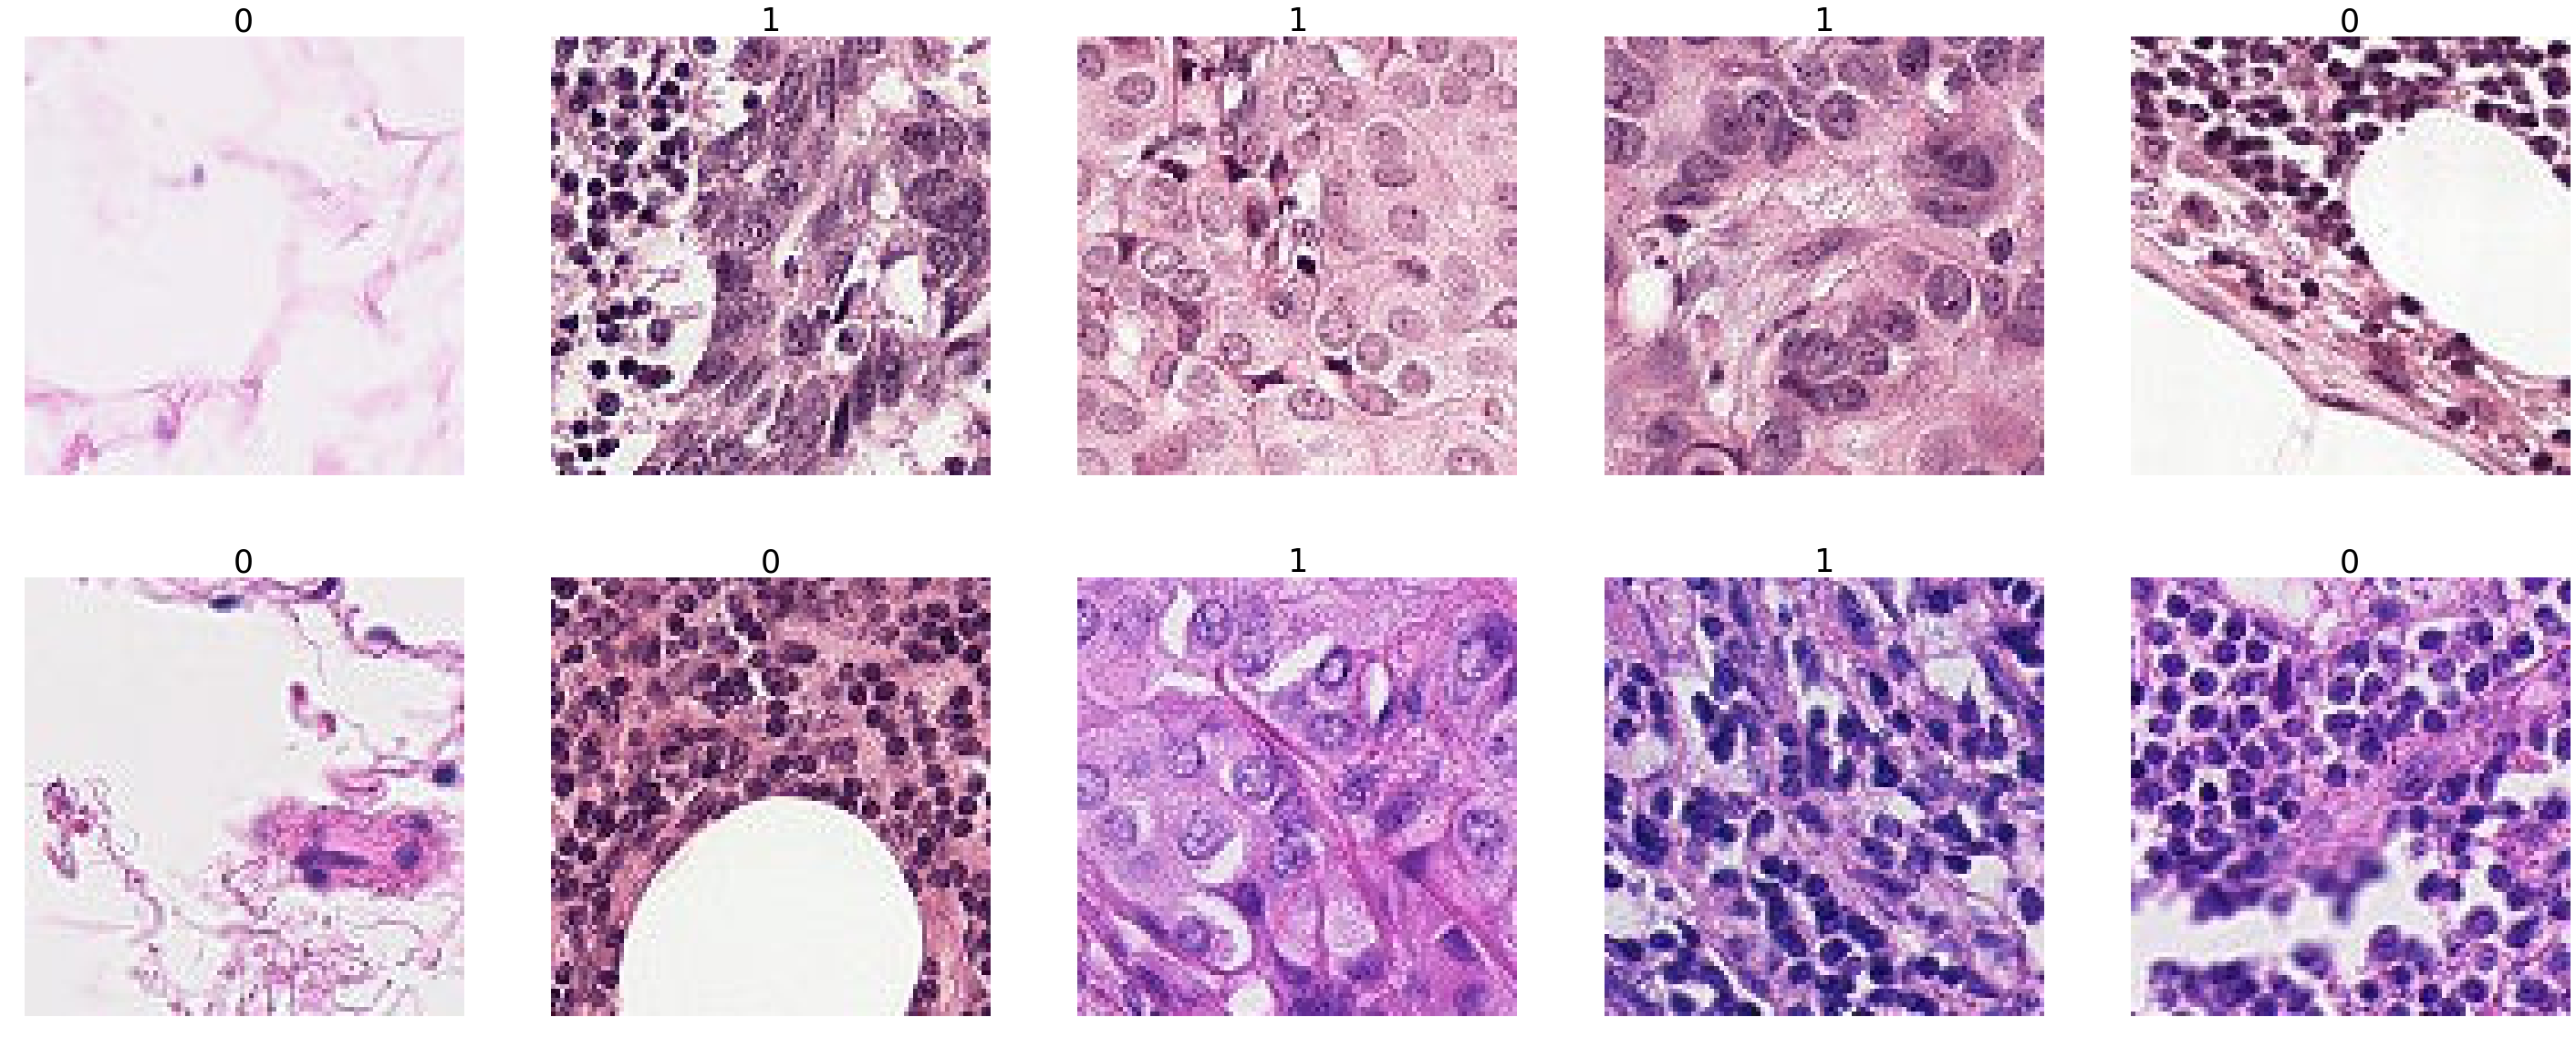

In [4]:
def display_random_data(dataframe, path, rows):

    imgs = dataframe.sample(rows *2)
    fig, axarr = plt.subplots(2, rows, figsize=(rows*10, rows*4))

    for i in range(1,rows*2+1):
        img_path = path + imgs.iloc[i-1]['id'] + '.tif'
        img = image.load_img(img_path, target_size=(96, 96))
        img = image.img_to_array(img)/255
        axarr[i//(rows+1),i%rows].imshow(img)
        axarr[i//(rows+1),i%rows].set_title(imgs.iloc[i-1]['label'], fontsize=35)
        axarr[i//(rows+1),i%rows].axis('off')
        
display_random_data(df,TRAIN_PATH, 5)

## Data Generator

In [5]:
#add .tif to ids in the dataframe to use flow_from_dataframe
df["id"]=df["id"].apply(lambda x : x +".tif")
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [7]:
train_generator=train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=TRAIN_PATH,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=64,
    shuffle=True,
    class_mode="binary",
    target_size=(96,96))

Found 220023 validated image filenames belonging to 2 classes.


In [8]:
valid_generator=train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=TRAIN_PATH,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=64,
    shuffle=True,
    class_mode="binary",
    target_size=(96,96))

Found 0 validated image filenames belonging to 2 classes.


## Buil Model

In [9]:
def build_model():
    # Initialising the CNN
    classifier = Sequential()

    classifier.add(Convolution2D(32, (3, 3), input_shape = (96, 96, 3), activation = 'relu'))

    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Convolution2D(32, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))

    classifier.add(Flatten())

    classifier.add(Dense(128, activation = 'relu'))
    classifier.add(Dense(1, activation = 'sigmoid'))

    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return classifier

In [10]:
classifier = build_model()
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 15488)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1982592   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [11]:
history = classifier.fit_generator(train_generator,
                              steps_per_epoch=train_generator.n//train_generator.batch_size, 
                              validation_data=valid_generator,
                              validation_steps=valid_generator.n//valid_generator.batch_size,
                              epochs=EPOCHS)

Train for 3437 steps
Epoch 1/10
3437/3437 [==============================] - 1046s 304ms/step - loss: 0.4435 - accuracy: 0.7968
Epoch 2/10
3437/3437 [==============================] - 645s 188ms/step - loss: 0.3662 - accuracy: 0.8418
Epoch 3/10
3437/3437 [==============================] - 647s 188ms/step - loss: 0.3441 - accuracy: 0.8520
Epoch 4/10
3437/3437 [==============================] - 651s 189ms/step - loss: 0.3268 - accuracy: 0.8609
Epoch 5/10
3437/3437 [==============================] - 640s 186ms/step - loss: 0.3169 - accuracy: 0.8658
Epoch 6/10
3437/3437 [==============================] - 643s 187ms/step - loss: 0.3095 - accuracy: 0.8695
Epoch 7/10
3437/3437 [==============================] - 640s 186ms/step - loss: 0.3029 - accuracy: 0.8727
Epoch 8/10
3437/3437 [==============================] - 642s 187ms/step - loss: 0.2950 - accuracy: 0.8767
Epoch 9/10
3437/3437 [==============================] - 641s 186ms/step - loss: 0.2899 - accuracy: 0.8784
Epoch 10/10
3437/3437 [=

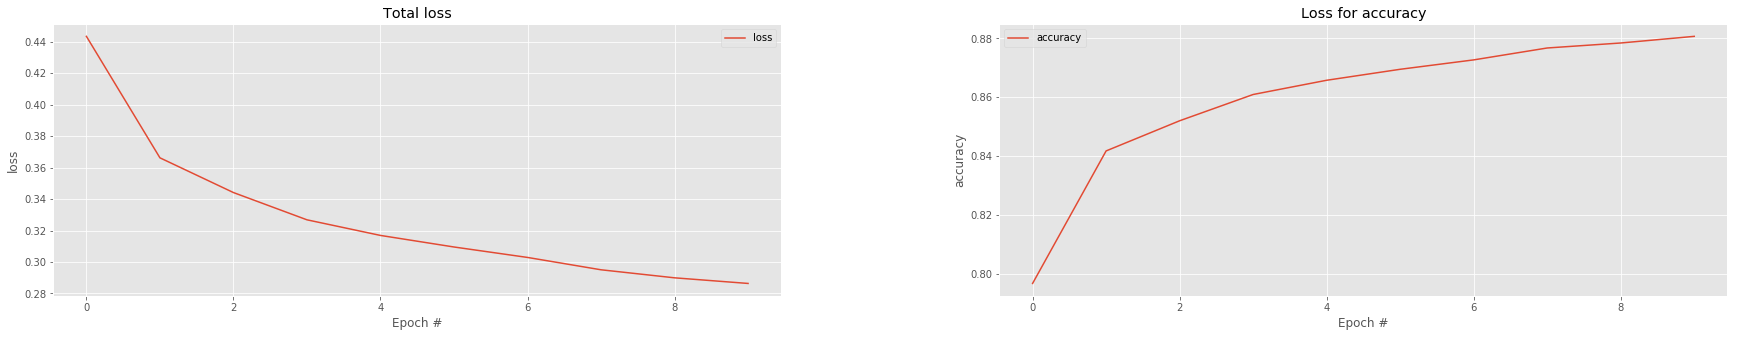

In [16]:
def analyse_results(epochs):
    metrics = ['loss', "accuracy"]
        
    plt.style.use("ggplot")
    (fig, ax) = plt.subplots(1, 2, figsize=(30, 5))
    fig.subplots_adjust(hspace=0.1, wspace=0.3)

    for (i, l) in enumerate(metrics):
        title = "Loss for {}".format(l) if l != "loss" else "Total loss"
        ax[i].set_title(title)
        ax[i].set_xlabel("Epoch #")
        ax[i].set_ylabel(l.split('_')[-1])
        ax[i].plot(np.arange(0, epochs), history.history[l], label=l)
        ax[i].legend() 

if EPOCHS > 1 and saved_model == False:        
    analyse_results(EPOCHS)

## Predictions

In [17]:
test_path = '/kaggle/input/histopathologic-cancer-detection/test/'
df_test = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
df_test["id"]=df_test["id"].apply(lambda x : x +".tif")

In [18]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                 samplewise_std_normalization= True)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_path,
    x_col="id",
    y_col=None,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=64,
    class_mode=None,
    shuffle=False,
)

/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:355: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 57458 validated image filenames.


In [19]:
test_generator.reset()
pred=classifier.predict_generator(test_generator,verbose=1).ravel()

898/898 [==============================] - 180s 201ms/step


## CSV Submission

In [20]:
results = dict(zip(test_generator.filenames, pred))

label = []
for i in range(len(df_test["id"])):
    label.append(results[df_test["id"][i]])
    
df_test["id"]=df_test["id"].apply(lambda x : x[:-4])

In [21]:
submission=pd.DataFrame({"id":df_test["id"],
                      "label":label})
submission.to_csv("submission.csv",index=False)
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.0
3,2c35657e312966e9294eac6841726ff3a748febf,0.0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.0
